In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report, 
                             roc_curve, auc)

# Set plotting style
sns.set_style('whitegrid')

In [2]:
# Load the dataset
credit_card_data = pd.read_csv('creditcard.csv')

# Display the first few rows
print(credit_card_data.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

Class
0    284315
1       492
Name: count, dtype: int64


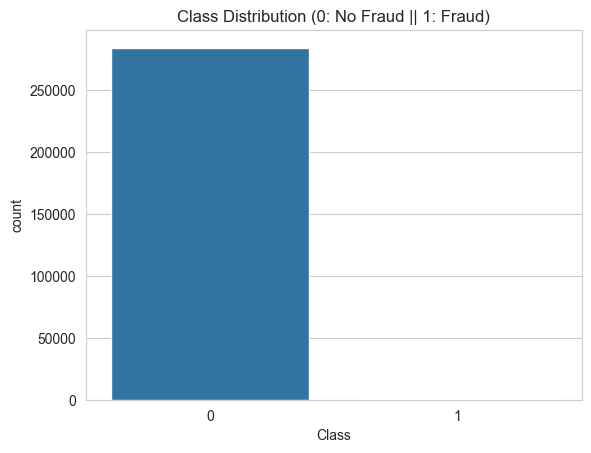

C:\Users\sasal\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


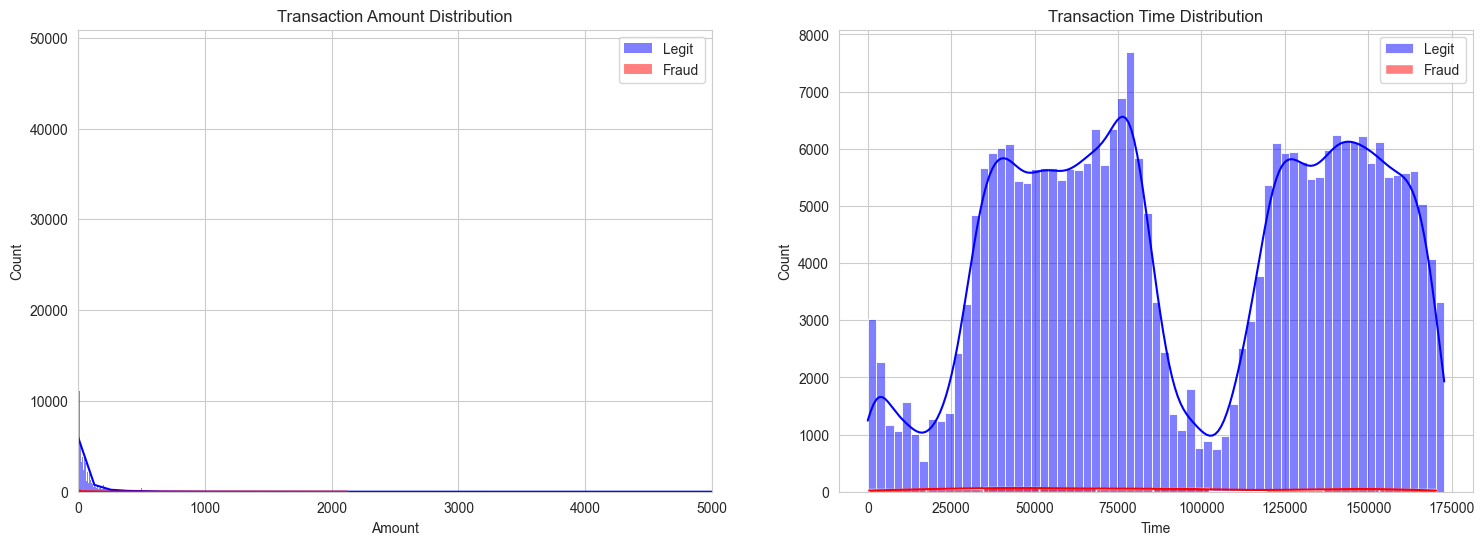

In [3]:
# Check class distribution
print(credit_card_data['Class'].value_counts())
sns.countplot(x='Class', data=credit_card_data)
plt.title('Class Distribution (0: No Fraud || 1: Fraud)')
plt.show()

# Compare the distribution of 'Amount' and 'Time' for both classes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Amount Distribution
sns.histplot(data=credit_card_data[credit_card_data['Class'] == 0], x='Amount', ax=ax1, color='b', kde=True, label='Legit')
sns.histplot(data=credit_card_data[credit_card_data['Class'] == 1], x='Amount', ax=ax1, color='r', kde=True, label='Fraud')
ax1.set_title('Transaction Amount Distribution')
ax1.set_xlim(0, 5000) # Limiting x-axis for better visibility
ax1.legend()

# Time Distribution
sns.histplot(data=credit_card_data[credit_card_data['Class'] == 0], x='Time', ax=ax2, color='b', kde=True, label='Legit')
sns.histplot(data=credit_card_data[credit_card_data['Class'] == 1], x='Time', ax=ax2, color='r', kde=True, label='Fraud')
ax2.set_title('Transaction Time Distribution')
ax2.legend()

plt.show()

In [5]:
# The 'V' columns are already scaled, but 'Time' and 'Amount' are not.
scaler = StandardScaler()
credit_card_data['scaled_Amount'] = scaler.fit_transform(credit_card_data['Amount'].values.reshape(-1, 1))
credit_card_data['scaled_Time'] = scaler.fit_transform(credit_card_data['Time'].values.reshape(-1, 1))

# Drop the original 'Time' and 'Amount' columns
credit_card_data.drop(['Time', 'Amount'], axis=1, inplace=True)

# Separate features (X) and target (Y)
X = credit_card_data.drop('Class', axis=1)
Y = credit_card_data['Class']

# Split the entire dataset into training and testing sets (70% train, 30% test)
# This is done BEFORE resampling to ensure the test set reflects the real-world imbalance
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

In [6]:
print("Class distribution before SMOTE:", Y_train.value_counts())

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

print("Class distribution after SMOTE:", Y_train_resampled.value_counts())

Class distribution before SMOTE: Class
0    199020
1       344
Name: count, dtype: int64


c:\Users\sasal\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\sasal\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Class distribution after SMOTE: Class
0    199020
1    199020
Name: count, dtype: int64


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Store F1 scores for visualization
f1_scores = {}

for name, model in models.items():
    print(f"--- Evaluating {name} ---")
    
    # Train on the resampled data
    model.fit(X_train_resampled, Y_train_resampled)
    
    # Predict on the original imbalanced test data
    Y_pred = model.predict(X_test)
    
    print(f"Classification Report for {name}:")
    print(classification_report(Y_test, Y_pred))
    
    f1_scores[name] = f1_score(Y_test, Y_pred)

--- Evaluating Logistic Regression ---
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.88      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.55     85443
weighted avg       1.00      0.98      0.99     85443

--- Evaluating Random Forest ---


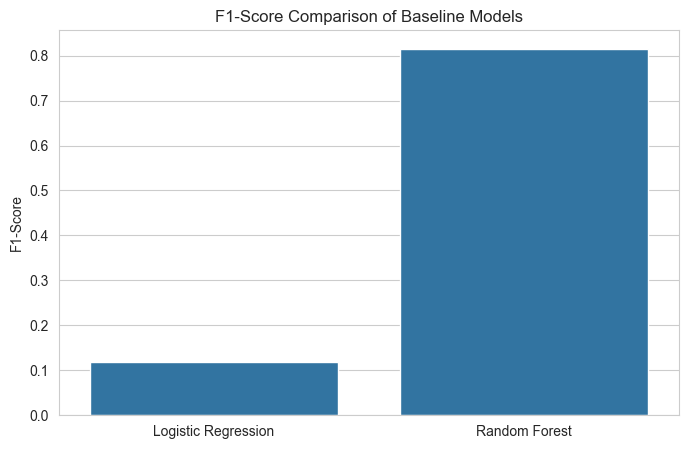

In [20]:
# Create a bar plot of the F1 scores
plt.figure(figsize=(8, 5))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()))
plt.title('F1-Score Comparison of Baseline Models')
plt.ylabel('F1-Score')
plt.show()

In [21]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,           # 3-fold cross-validation
                           scoring='f1',   # Focus on F1-score
                           verbose=2,      # Show progress
                           n_jobs=-1)      # Use all available CPU cores

# Fit the grid search to the resampled training data
grid_search.fit(X_train_resampled, Y_train_resampled)

# Get the best model
best_rf_model = grid_search.best_estimator_

print(f"\nBest Parameters Found: {grid_search.best_params_}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits


KeyboardInterrupt: 

In [ ]:
# Evaluate the optimized model
Y_pred_optimized = best_rf_model.predict(X_test)

print("\n--- Classification Report for Optimized Random Forest ---")
print(classification_report(Y_test, Y_pred_optimized))

print("\n--- Confusion Matrix for Optimized Random Forest ---")
plot_confusion_matrix(Y_test, Y_pred_optimized, "Optimized Random Forest")

In [ ]:
# Get prediction probabilities for the positive class (Fraud)
y_prob_lr = models["Logistic Regression"].predict_proba(X_test)[:, 1]
y_prob_rf_optimized = best_rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve data
fpr_lr, tpr_lr, _ = roc_curve(Y_test, y_prob_lr)
auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(Y_test, y_prob_rf_optimized)
auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Optimized Random Forest (AUC = {auc_rf:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess') # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()